In [5]:
%load_ext autoreload
%autoreload 2
import os
import matplotlib.pyplot as plt
import seaborn as sns
from os.path import join
from tqdm import tqdm
import pandas as pd
import sys
import joblib
from scipy.special import softmax
import sasc.config
import numpy as np
from collections import defaultdict
from copy import deepcopy
import pandas as pd
from sasc import config
import sasc.analyze_helper
# from sasc.modules.fmri_module import convert_module_num_to_voxel_num

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


**Note: not sure these are properly adjusted for the trim**

In [6]:
pilot_name = 'pilot_story_data.pkl'
pilot_data_dir = join(config.PILOT_STORY_DATA_DIR, '20230504')
resp_np_files = os.listdir(pilot_data_dir)
resps_dict = {k: np.load(join(pilot_data_dir, k)) for k in tqdm(resp_np_files)}
stories_data_dict = joblib.load(
    join(sasc.config.RESULTS_DIR, 'processed', 'pilot_story_data.pkl'))

default_story_idxs = np.where(
    np.array(stories_data_dict['story_setting']) == 'default')[0]

100%|██████████| 6/6 [00:22<00:00,  3.79s/it]


In [7]:
def get_resp_chunks_list(stories_data_dict, resps_dict, default_story_idxs):
    resp_chunks_list = []
    for story_num in default_story_idxs:
        rows = stories_data_dict["rows"][story_num]

        # get resp_chunks
        resp_story = resps_dict[
            stories_data_dict["story_name_new"][story_num].replace(
                '_resps', '')
        ].T  # (voxels, time)
        timing = stories_data_dict["timing"][story_num]
        if 'paragraphs' in stories_data_dict.keys():
            paragraphs = stories_data_dict["paragraphs"][story_num]
        else:
            paragraphs = stories_data_dict["story_text"][story_num].split(
                "\n\n")
        # paragraphs = stories_data_dict["story_text"][story_num].split("\n\n")
        if pilot_name in ['pilot3_story_data.pkl']:
            paragraphs = [sasc.analyze_helper.remove_repeated_words(
                p) for p in paragraphs]
        assert len(paragraphs) == len(
            rows), f"{len(paragraphs)} != {len(rows)}"
        resp_chunks = sasc.analyze_helper.get_resps_for_paragraphs(
            timing, paragraphs, resp_story, offset=2)
        assert len(resp_chunks) <= len(paragraphs)

    # for story_num in range(6):  # range(1, 7)
    #     rows = story_data["rows"][story_num]
    #     paragraphs = story_data["story_text"][story_num].split("\n\n")
    #     timing = story_data["timing"][story_num]

    #     # (voxels, time)
    #     resp_story = resps_dict[story_data["story_name_new"][story_num]].T
    #     resp_chunks = sasc.analyze_helper.get_resp_chunks(
    #         timing, paragraphs, resp_story, apply_offset=False)
        resp_chunks[0] *= np.nan

        args = np.argsort(rows["expl"].values)
        resp_chunks_list.append(
            [resp_chunks[i][rows['voxel_num']] for i in args])

    return resp_chunks_list


resp_chunks_list = get_resp_chunks_list(
    stories_data_dict, resps_dict, default_story_idxs)
# resp_chunks_arr = np.array(resp_chunks_list).mean(axis=0)
expls = stories_data_dict["rows"][0].sort_values(by="expl")["expl"].values

### Visualize curves

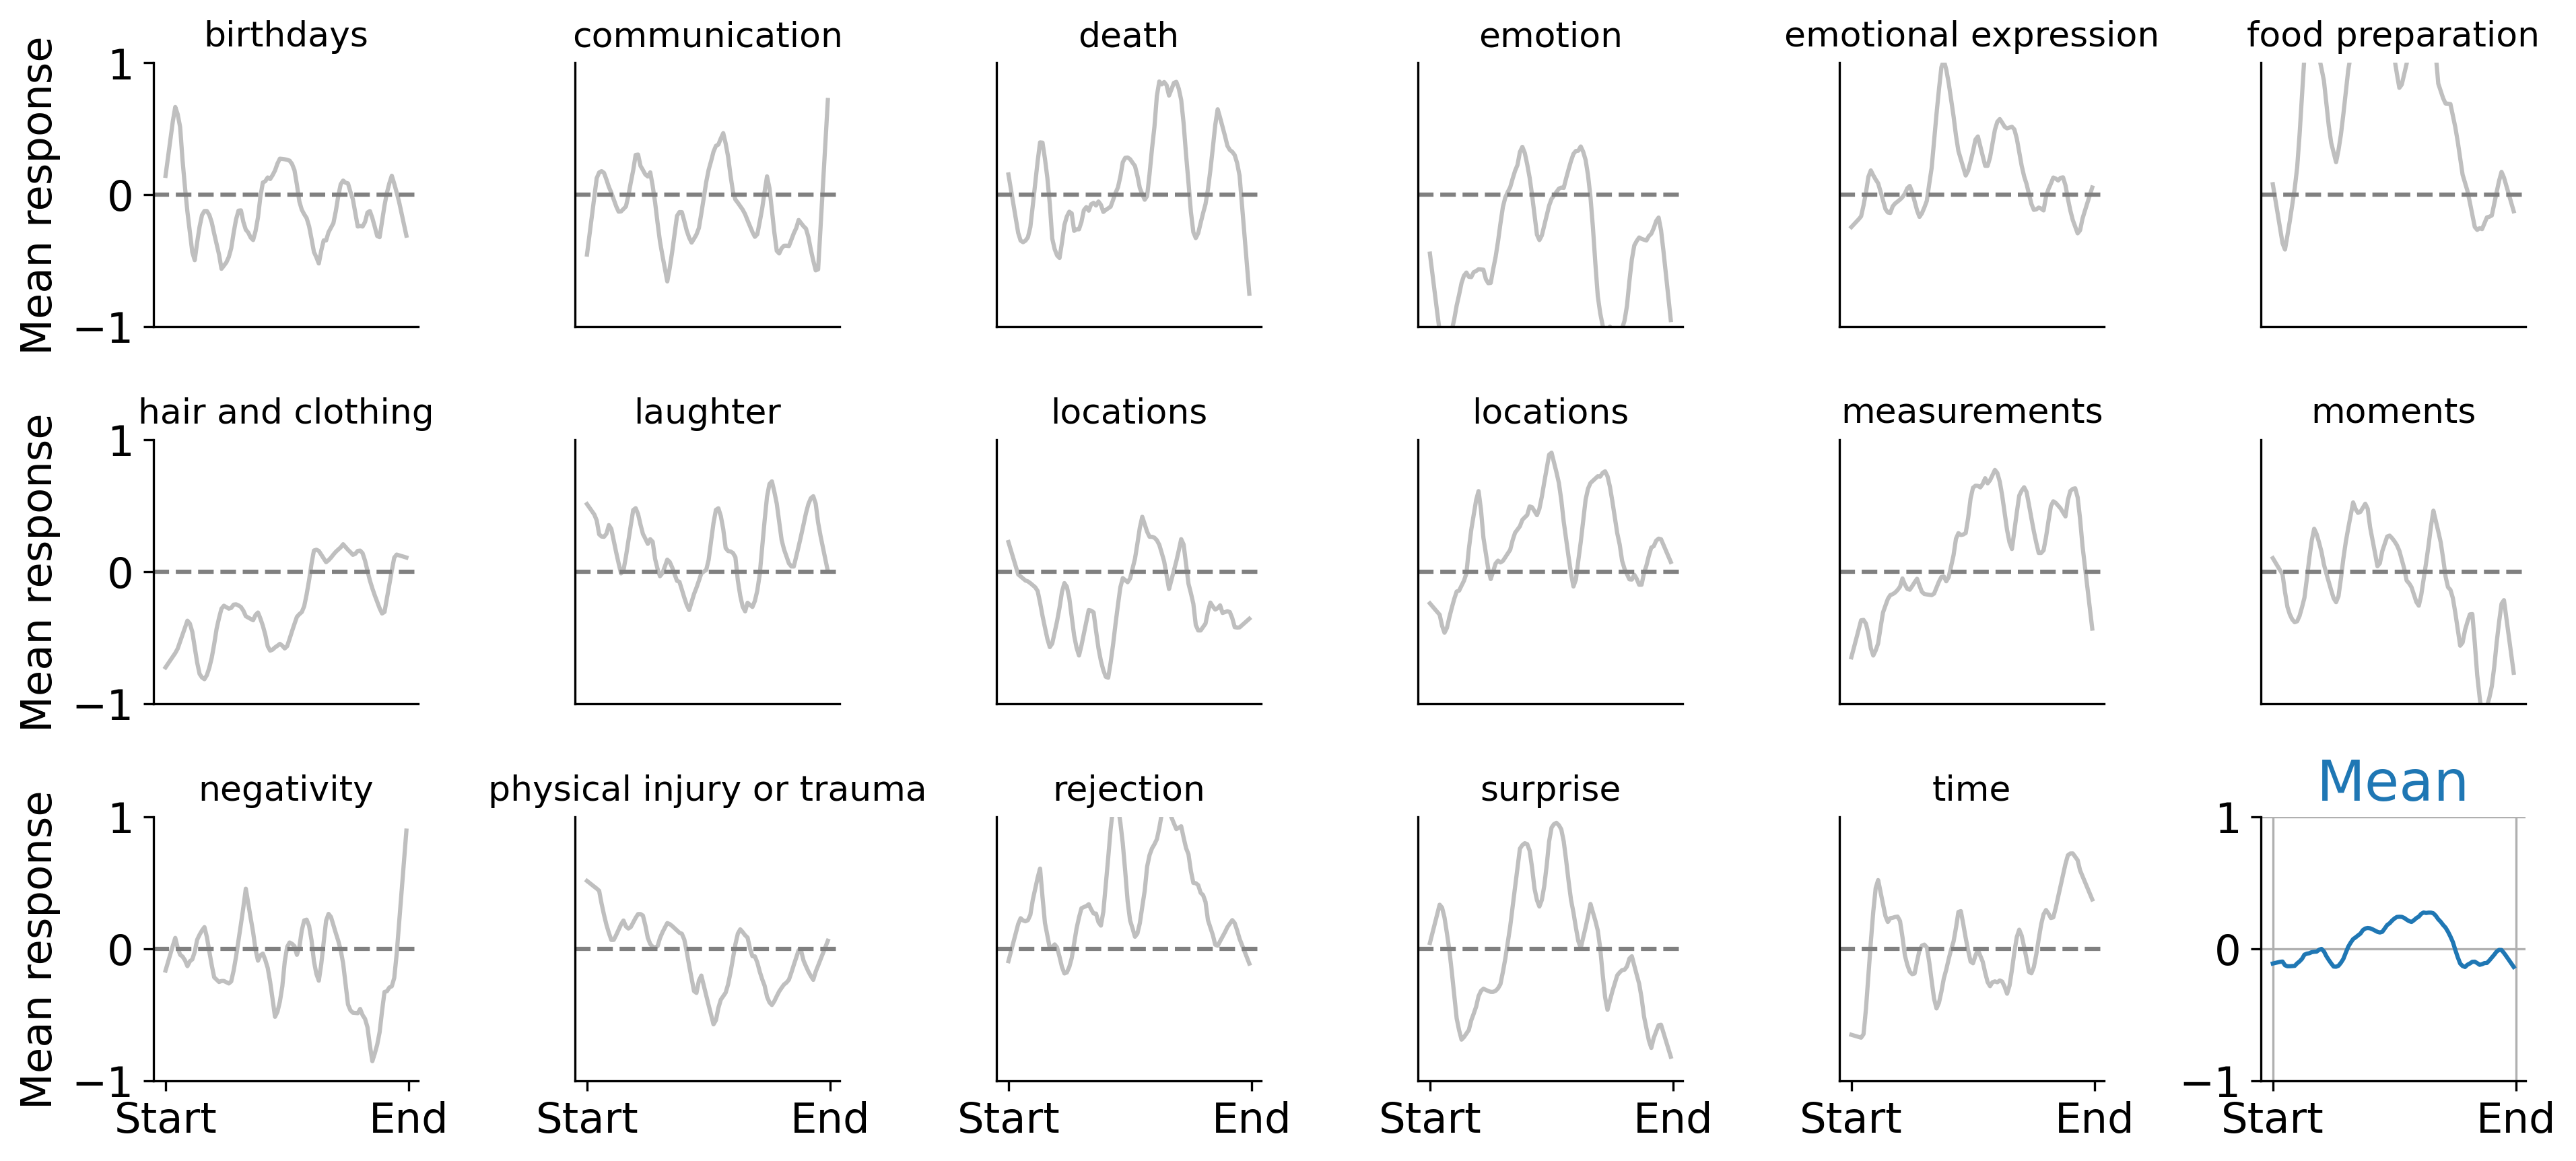

In [8]:
viz_mean = True

# resp_chunks_list (n_stories, n_voxels (driving), n_voxels (resp), n_time)
n_voxels = len(resp_chunks_list[0])
n_stories = len(resp_chunks_list)
plt.figure(figsize=(13, 6), dpi=300)
resps_rep_means = []
resps_rep_all = []
C = 6
R = 3
for voxel_num in range(n_voxels):
    plt.subplot(R, C, voxel_num + 1)
    resps_rep = []
    for story_num in range(n_stories):
        # print(resp_chunks_list[story_num][voxel_num])
        resps_rep.append(resp_chunks_list[story_num][voxel_num][voxel_num])
    resps_rep = sorted(resps_rep, key=lambda x: len(x))

    # interpolate each story to 100 time points
    resps_rep_interp = []
    for resp_rep in resps_rep:
        resps_rep_interp.append(
            np.interp(np.linspace(0, 1, 100), np.linspace(0, 1, len(resp_rep)),
                      resp_rep))
    resps_rep_interp = np.array(resps_rep_interp)
    resps_rep_mean = np.nanmean(resps_rep_interp, axis=0)

    # print('shape', resps_rep_mean.shape)
    if viz_mean:
        plt.plot(resps_rep_mean, color='gray', alpha=0.5)
        plt.axhline(0, color='gray', linestyle='--')
        plt.ylim(-1, 1)

        if voxel_num < C * (R - 1):
            plt.xticks([])
        else:
            plt.xticks([0, 100], ['Start', 'End'])
    else:
        cmap = sns.color_palette("Blues", as_cmap=True)
        for i, resp in enumerate(resps_rep):
            plt.plot(resp, color=cmap(i / len(resps_rep)), alpha=0.5)
        plt.ylim(-3, 3)

    if voxel_num % C != 0:
        plt.yticks([])
    else:
        plt.ylabel('Mean response')

    resps_rep_means.append(resps_rep_mean)
    resps_rep_all.append(resps_rep)
    plt.title(expls[voxel_num], fontsize='small')


plt.subplot(R, C, voxel_num + 2)
plt.title('Mean', color='C0')
plt.plot(np.array(resps_rep_means).mean(axis=0), color='C0')
plt.grid()
plt.ylim(-1, 1)
plt.xticks([0, 100], ['Start', 'End'])
plt.tight_layout()

In [10]:
resps_list = sum(resps_rep_all, [])
lens = np.array([len(x) for x in resps_list])
print('mean resp', np.nanmean(np.concatenate(resps_list)))

mean resp 0.021706719309152793


### Choose a couple for the intro fig

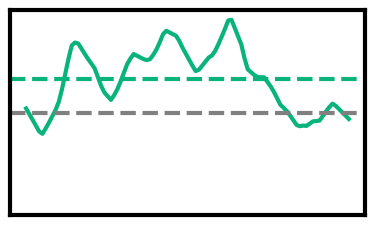

In [18]:
plt.figure(figsize=(4, 2.5))
plt.plot(resps_rep_means[5], '-', color='#08b47c', lw=3)
plt.axhline(0, color='gray', linestyle='--', lw=3)
baseline = np.mean(resps_rep_means[5])
plt.axhline(baseline, color='#08b47c', linestyle='--', lw=3)
plt.ylim(-2, 2)
plt.xticks([])
plt.yticks([])
# turn on all splines
for spine in plt.gca().spines.values():
    spine.set_visible(True)

    # make spline thick
    spine.set_linewidth(3)
plt.savefig(join(sasc.config.RESULTS_DIR, 'figs',
            'misc', 'food_prep_avg_driving_resp.pdf'), bbox_inches='tight')

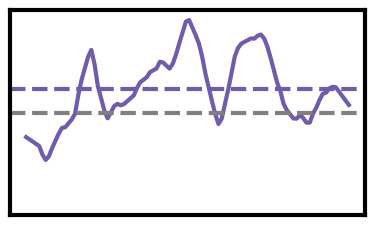

In [24]:
plt.figure(figsize=(4, 2.5))
plt.plot(resps_rep_means[9], '-', color='#705cac', lw=3)
plt.axhline(0, color='gray', linestyle='--', lw=3)
plt.axhline(np.mean(resps_rep_means[9]), color='#705cac', linestyle='--', lw=3)
plt.ylim(-1, 1)
plt.xticks([])
plt.yticks([])
# turn on all splines
for spine in plt.gca().spines.values():
    spine.set_visible(True)

    # make spline thick
    spine.set_linewidth(3)
plt.savefig(join(sasc.config.RESULTS_DIR, 'figs',
            'misc', 'locations_avg_driving_resp.pdf'), bbox_inches='tight')

# Analysis by TR length

/home/chansingh/imodelsx/.venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/chansingh/imodelsx/.venv/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Text(0.5, 0, 'TRs')

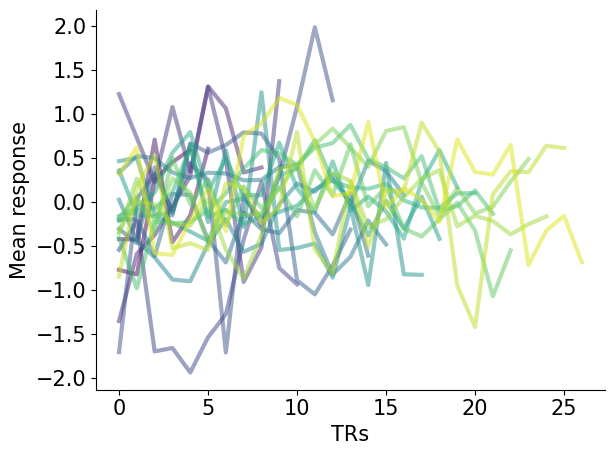

In [12]:
resp_means_by_len = []
counts_by_len = []
resp_means_by_len_5 = []
cmap = sns.color_palette("viridis", as_cmap=True)
for i, x in enumerate(np.unique(lens)):
    resp_mean = np.zeros(x)
    count = 0
    for resp in resps_list:
        if len(resp) == x:
            resp_mean += resp
            count += 1
    counts_by_len.append(count)
    resp_mean /= count
    plt.plot(resp_mean, label=x, color=cmap(
        i / len(np.unique(lens))), alpha=0.5, lw=3)
    resp_means_by_len.append(np.mean(resp_mean))
    resp_means_by_len_5.append(np.mean(resp_mean[5:]))
plt.ylabel('Mean response')
plt.xlabel('TRs')
# plt.legend()

In [13]:
out = pd.DataFrame(
    {"Paragraph length (TRs)": np.unique(lens), "Count": counts_by_len, "Response mean": resp_means_by_len,
     'Response mean (excluding 1st 5 TRs)': resp_means_by_len_5}
).round(2)
out.style.format(precision=2).background_gradient(cmap='viridis')

,Paragraph length (TRs),Count,Response mean,Response mean (excluding 1st 5 TRs)
0,5,1,-0.06,nan
1,6,2,-0.02,0.61
2,9,1,0.12,0.78
3,10,2,0.54,0.35
4,11,1,-0.98,-0.78
5,13,1,0.14,0.36
6,14,2,0.03,0.03
7,15,5,-0.25,-0.30
8,16,7,0.09,-0.05
9,17,7,-0.18,-0.02


In [14]:
out[out['Paragraph length (TRs)'] <
    23]['Response mean (excluding 1st 5 TRs)'].mean()

0.08714285714285712

In [15]:
out[out['Paragraph length (TRs)'] >=
    23]['Response mean (excluding 1st 5 TRs)'].mean()

0.06999999999999999